In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

In [2]:
#calculate fft @params signal and rate
def calculate_fft(signal, rate):
    signal_length = len(signal)
    frequency = np.fft.rfftfreq(signal_length, d = 1/rate)
    #mean normalization of length of signal
    magnitude = abs(np.fft.rfft(signal)/signal_length) 
    return (magnitude, frequency)

In [3]:
#calculate low and hig frequency because we have dead spots in signal
#we do this to get atleats a threshold value of amps
def envelope(signal, rate, threshold):
    mask = []
    signal = pd.Series(signal).apply(np.abs)
    signal_mean = signal.rolling(window=int(rate/10), min_periods = 1, center = True).mean()
    for mean in signal_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [4]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(1):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [5]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(1):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [6]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(1):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [7]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(1):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [8]:
## file operations

##read file labels
data_frame = pd.read_csv('dataset_minor2.csv')
data_frame.set_index('cough_filename', inplace=True)

print('Extract files with labels')
for index, row in data_frame.iterrows():
    print(index,row)
    if row['corona_test']=='negative':
        rate, signal = wavfile.read('./clinical/converted_seg/cneg/'+index)
        data_frame.at[index, 'length'] = signal.shape[0]/rate
    else:
        rate, signal = wavfile.read('./clinical/converted_seg/cpos/'+index)
        data_frame.at[index, 'length'] = signal.shape[0]/rate


classes = list(np.unique(data_frame.corona_test))
class_dist = data_frame.groupby(['corona_test'])['length'].mean()
print(classes)


data_frame.reset_index(inplace=True)

##datapoints
signals = {}
fft = {}
fbank = {}
mfccs = {}

print("Reading audio files with librosa")
for c in tqdm(classes):
    wav_file = data_frame[data_frame.corona_test == c].iloc[0,0]
    print(wav_file)
    if c == 'negative':
        signal, rate = librosa.load('clinical/converted_seg/cneg/'+ wav_file, sr=44100)
    else:
        signal, rate = librosa.load('clinical/converted_seg/cpos/'+ wav_file, sr=44100)
    
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calculate_fft(signal, rate)

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], rate, numcep=40, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel

Extract files with labels
neg-0421-083-cough-m-53-0.wav corona_test    negative
Name: neg-0421-083-cough-m-53-0.wav, dtype: object
neg-0421-083-cough-m-53-1.wav corona_test    negative
Name: neg-0421-083-cough-m-53-1.wav, dtype: object
neg-0421-083-cough-m-53-10.wav corona_test    negative
Name: neg-0421-083-cough-m-53-10.wav, dtype: object
neg-0421-083-cough-m-53-11.wav corona_test    negative
Name: neg-0421-083-cough-m-53-11.wav, dtype: object
neg-0421-083-cough-m-53-12.wav corona_test    negative
Name: neg-0421-083-cough-m-53-12.wav, dtype: object
neg-0421-083-cough-m-53-13.wav corona_test    negative
Name: neg-0421-083-cough-m-53-13.wav, dtype: object
neg-0421-083-cough-m-53-14.wav corona_test    negative
Name: neg-0421-083-cough-m-53-14.wav, dtype: object
neg-0421-083-cough-m-53-15.wav corona_test    negative
Name: neg-0421-083-cough-m-53-15.wav, dtype: object
neg-0421-083-cough-m-53-16.wav corona_test    negative
Name: neg-0421-083-cough-m-53-16.wav, dtype: object
neg-0421-083-co

  0%|          | 0/2 [00:00<?, ?it/s]

 corona_test    positive
Name: pos-0421-092-cough-m-53-12.wav, dtype: object
pos-0421-092-cough-m-53-13.wav corona_test    positive
Name: pos-0421-092-cough-m-53-13.wav, dtype: object
pos-0421-092-cough-m-53-3.wav corona_test    positive
Name: pos-0421-092-cough-m-53-3.wav, dtype: object
pos-0421-092-cough-m-53-5.wav corona_test    positive
Name: pos-0421-092-cough-m-53-5.wav, dtype: object
pos-0421-092-cough-m-53-6.wav corona_test    positive
Name: pos-0421-092-cough-m-53-6.wav, dtype: object
pos-0421-092-cough-m-53-7.wav corona_test    positive
Name: pos-0421-092-cough-m-53-7.wav, dtype: object
pos-0421-092-cough-m-53-9.wav corona_test    positive
Name: pos-0421-092-cough-m-53-9.wav, dtype: object
pos-0421-093-cough-f-24-0.wav corona_test    positive
Name: pos-0421-093-cough-f-24-0.wav, dtype: object
pos-0421-093-cough-f-24-1.wav corona_test    positive
Name: pos-0421-093-cough-f-24-1.wav, dtype: object
pos-0421-093-cough-f-24-2.wav corona_test    positive
Name: pos-0421-093-cough-f-

 50%|█████     | 1/2 [00:02<00:02,  2.26s/it]

pos-0421-084-cough-m-50-0.wav


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


In [9]:
#writing cleaned files for training

print("Writing clean files for calssification training")
for index, row in data_frame.iterrows():
#     for f in tqdm(data_frame.cough_filename):
    try:
        if(row['corona_test']=='negative'):
            signal, rate = librosa.load('./clinical/converted_seg/cneg/'+row["cough_filename"], sr = 16000)
        else:
            signal, rate = librosa.load('./clinical/converted_seg/cpos/'+row["cough_filename"], sr = 16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='cleanfiles/'+row["cough_filename"], rate = rate, data= signal[mask])
    except FileNotFoundError:
        print("Unexpected error while reading files:", arg)


Writing clean files for calssification training


In [10]:
# #writing files for testing
# print(os.listdir('testcleanfiles'))

# print("Writing clean files for calssification")
# for f in tqdm(data_frame.cough_filename):
#     try:
#         signal, rate = librosa.load('testsounds/'+f, sr = 16000)
#         mask = envelope(signal, rate, 0.0005)
#         wavfile.write(filename='testcleanfiles/'+f, rate = rate, data= signal[mask])
#     except FileNotFoundError:
#         print("Unexpected error while reading files:", arg)


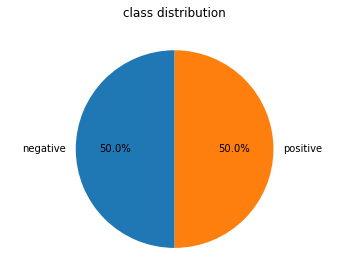

In [11]:
#plot class distribution
fig, ax = plt.subplots()
ax.set_title("class distribution", y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()

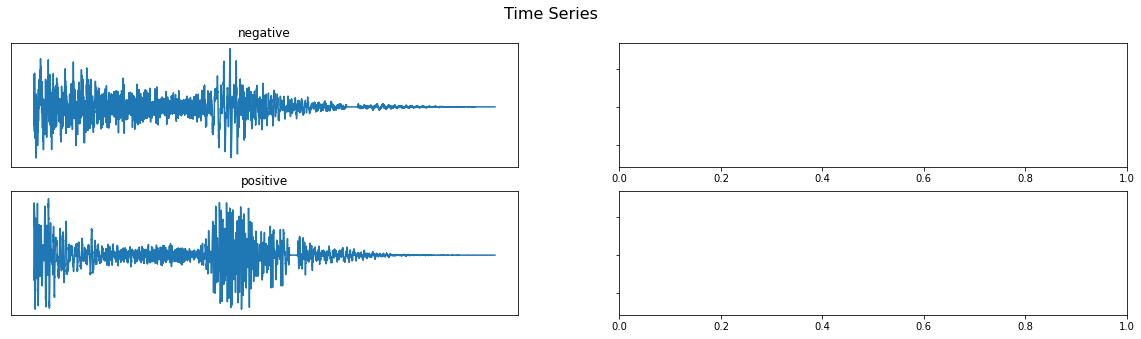

In [12]:
#plot raw signal
plot_signals(signals)
plt.show()

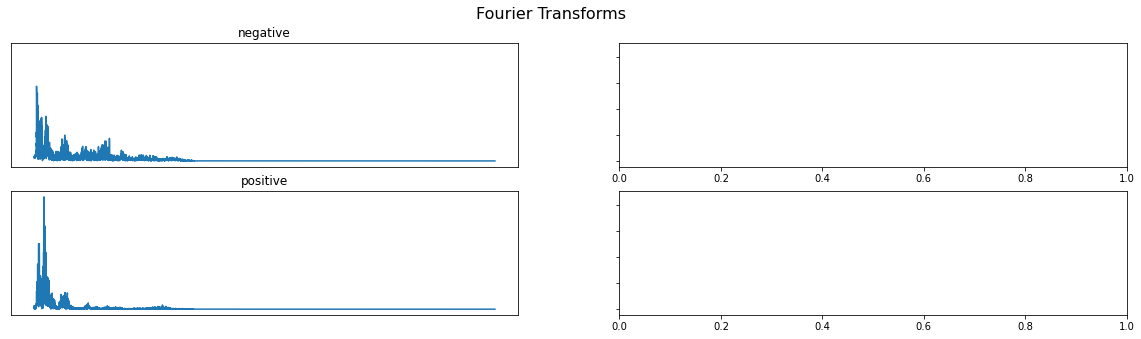

In [13]:
#plot fft signals
plot_fft(fft)
plt.show()

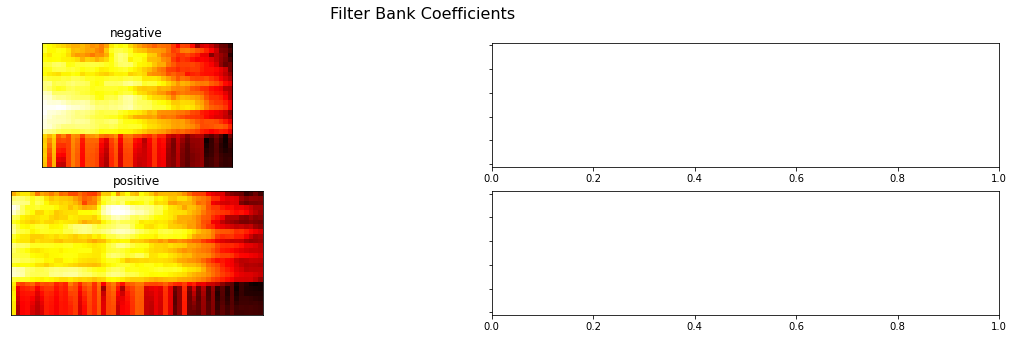

In [14]:
#plot Filter bank energy
plot_fbank(fbank)
plt.show()

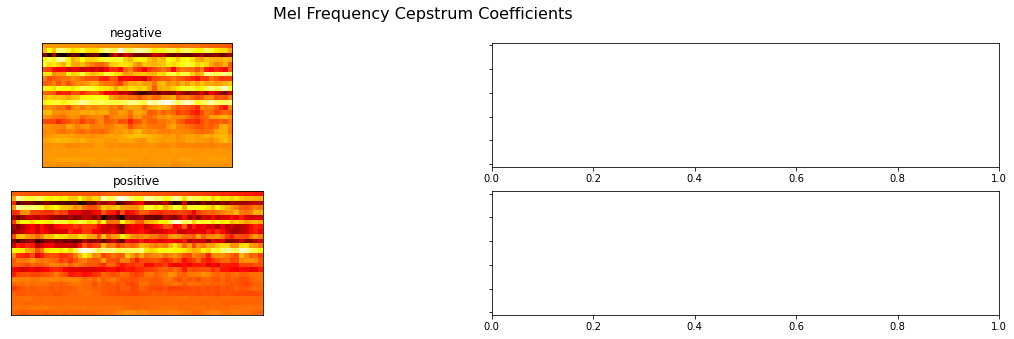

In [15]:
#plot mfcc 

plot_mfccs(mfccs)
plt.show()